# Optimal Flyer Routing

## Problem Description

Data in hand:
* ~2300 potential locations within ~50 miles of St. Paul.
* Each location node has a **very** rough estimate (based on < 30 collected samples, i.e. basically guessing) of bulletin-board probability [P(bb)]
* geodesic distance from a single origin point to all nodes
* travel distances/durations from each of the visited location to several hundred nearby nodes (sourced from Gmaps API)

Parameters/Constraints:
* No location should be visited more than once
* Soft limit of 5hrs of travel time in a day (ignoring return time for simplicity)
    * Trying to maximize the number of visited locations in the time span, while favoring nodes with high P(bb)
* Traversal takes places over multiple days, repeating from the same start point
    * After each reset, visited nodes are removed, each node's P(bb) is updated, and a new optimal path is calculated

Challenges:
* Each new travel distance calculation requires a call to Gmaps API, which is a paid resource
    * Here API can be used a free(ish) alternative, but the travel estimates are worse
* Based on the limited amount of collected data, distance should be weighted more heavily than P(bb), but exacting a ratio is difficult

### Resources

Orienteering Problem:

http://chekuri.cs.illinois.edu/papers/orienteering-journal.pdf

http://chekuri.cs.illinois.edu/papers/orienteering.pdf

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0213777

https://github.com/cwbollinger/OP_simulator/blob/master/orienteering_solver.py

https://link.springer.com/article/10.1057/jors.1984.162

https://dl.acm.org/citation.cfm?id=2700604

https://github.com/mirgee/orienteering_problem_heuristics/blob/master/GRASP_AOP/

Constrained Least-cost Tour:

https://arxiv.org/pdf/1906.07754.pdf

https://patrickohara.github.io/CLT-problem/cltproblem.html#

https://github.com/torressa/cspy

Combinatorial Optimization:

https://en.wikipedia.org/wiki/Combinatorial_optimization

https://www.cvxpy.org/install/index.html

Vehicle Routing Problem:

https://en.wikipedia.org/wiki/Vehicle_routing_problem

https://developers.google.com/optimization/routing/cvrp

Traveling Salesman/General Graph Algorithms:

http://web.stanford.edu/~ashishg/msande111/notes/chapter5

https://www.youtube.com/watch?v=sOTUaT0aABc

https://en.wikipedia.org/wiki/Shortest_path_problem#Road_networks

https://en.wikipedia.org/wiki/K_shortest_path_routing

https://en.wikipedia.org/wiki/List_of_algorithms#Graph_algorithms

Uncategorized:

https://github.com/gboeing/urban-data-science/blob/master/15-Spatial-Cluster-Analysis/cluster-analysis.ipynb

https://github.com/coin-or/pulp

https://wiki.python.org/moin/PythonForOperationsResearch

https://pysal.readthedocs.io/en/latest/api.html

https://github.com/sacridini/Awesome-Geospatial#python

**Algorithm 1:** Adaptive heuristic for the Constrained Least-cost Cycle Problem

**input:** An undirected graph G with edge weights w : E(G) → ℕ and edge costs c : E(G) → ℕ;
the origin s* ∈ V(G); lower and upper weight thresholds W₁, W₂ ∈ ℕ.

1. Construct a directed, asymmetric graph (G') from the undirected graph G.
    * [build_auxiliary_node_connectivity](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.utils.build_auxiliary_node_connectivity.html?highlight=build%20aux#networkx.algorithms.connectivity.utils.build_auxiliary_node_connectivity)
2. For every pair of vertices u, v ∈ V(G'), compute the least-cost pair of vertex-disjoint paths ∆(u, v) between u and v.
    * [node_disjoint_paths](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.disjoint_paths.node_disjoint_paths.html)
3. From ∆(u, v), construct a simple cycle C. If s* ∈ C, then C is a candidate solution.
    * [simple_cycles](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html?highlight=simple%20cycle)

**output:** The least-cost weight-feasible simple cycle C* from all candidate solutions C.

### Setup & Initialization

In [1]:
import re
import json
import time
import inspect
import hashlib
import functools
from pathlib import Path
import urllib.parse as uparse
from collections import Counter
import itertools

import requests
import pickle
from pprint import pprint
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import scipy as sp
import cvxpy as cx

import googlemaps
import geopy
import geopy.distance as geodist
import geopandas as gpd; gpd.options.display_precision = 6
import shapely

import folium
import folium.plugins
from folium.plugins import MarkerCluster,FeatureGroupSubGroup

import plotly
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx

from bing_api import Bing
from here_api import Here
from _config import config

#### Convenience Functions

In [2]:
def destring_list(liststr,resep=r',\s*'):
    # 6 digits of precision is accurate to ~11cm, anything further is likely noise
    # https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude
    if not isinstance(liststr,str):
        return np.round(liststr,6)
    return np.round([*map(np.float,re.split(resep,liststr.strip('[( )]')))],6)

In [3]:
def asstr(latlon):
    return f'{latlon[0]},{latlon[1]}'

In [4]:
def coord_strcomp(x1,x2):
    return f'{x1[0]}{x1[1]}' == f'{x2[0]}{x2[1]}'

In [5]:
def partition_groups(iterable, n_groups=None, max_group_size=None):
    assert (n_groups or max_group_size) is not None, 'exactly one of `n_groups` or `max_group_size` must be provided'
    n_groups = n_groups if n_groups is not None else np.ceil(len(iterable)/(max_group_size))
    return np.array_split(iterable, n_groups)

In [6]:
def gpcode(coords):
    """Long runtime when API key is not provided"""
    url_path='https://plus.codes/api?'
    params = {'address':'{},{}'.format(*coords)}
    resp = requests.get(url_path, params)
    return resp.json()

#### Globals

In [7]:
RAD = 40000 # 40000m ≈ 25 miles
METERMILE = 1609.344
SOURCE = config.geo.CENTERW
BUDGET = 5*60*60 # 5 Hours

In [8]:
gmaps = googlemaps.Client(key=config.GMAPS_KEY, timeout=10, retry_over_query_limit=False)
here = Here(config.HERE_APPID,config.HERE_APPCODE)

## Data

**High Success**
* Universities (2/2)
* Community/Recreation Centers (3/3)
* Kwik Trip gas stations (4/4)

**Mixed Success**
* Gas stations general (4/11)
* Laundromats (1/4)

**Limited/No Success**
* Speedway gas stations (0/3)* (one location not recorded)

In [8]:
def update_prob(df, qpat, prob, qcol='place_name', inplace=False):
    df = df if inplace else df.copy()
    df.loc[df[qcol].str.contains(qpat,case=False),'prob_bb'] = prob
    return None if inplace else df

In [9]:
df_pdfly = pd.read_pickle('data/pdflyers_df.pkl')
df_oppos = pd.read_pickle('data/open_pos_df.pkl')
df_visit = pd.read_pickle('data/visited_details_all_df.pkl')

In [109]:
# Assign approx probabilities from collected data
df_pdfly['prob_bb'] = np.nan
update_prob(df_pdfly,'college|universit',1.0,inplace=True)
update_prob(df_pdfly,'rec(reation)?|community',1.0,qcol='keyword',inplace=True)
update_prob(df_pdfly,'kwik trip',1.0,qcol='place_name',inplace=True)
update_prob(df_pdfly,'speedway',0.0,qcol='place_name',inplace=True)
update_prob(df_pdfly,'laundr',1/4,qcol='place_name',inplace=True)
df_pdfly.loc[df_pdfly['keyword'].str.contains('gas station|convenience',case=False) & df_pdfly['prob_bb'].isna(),'prob_bb'] = 4/11
df_pdfly['prob_bb'].fillna(0.1,inplace=True)

In [10]:
# Some locations have multiple place_ids, but identical physical location, so we'll drop those for our purposes
# As well as having a unique index for cross ref with df_fdist
df_pdfly = df_pdfly.drop_duplicates('global_code').reset_index(drop=True)
# add consistent geodesic distance to CENTERW column
df_pdfly = df_pdfly.assign(distCW=df_pdfly.latlong.apply(lambda x: geodist.geodesic(config.geo.CENTERW,x).meters))

In [11]:
df_fdist = pd.read_pickle('data/all_dists_df.pkl')#.rename(lambda x: x.split('.')[1 if len(x.split('.')) > 1 else 0],axis=1).iloc[:,2:]
df_fdist_nb = df_fdist[(df_fdist.dest_ll.str[1] < -92.9) & (df_fdist.geodesic_o2d < 42000)]

In [12]:
llstr_idx = {asstr(SOURCE):0,**{asstr(v):k+1 for k,v in df_pdfly['latlong'].iteritems()}}
ll_idx = {tuple(SOURCE):0,**{tuple(v):k+1 for k,v in df_pdfly['latlong'].iteritems()}}
idx_ll = np.array(list(ll_idx.keys()))
idx2prob = {0:0.0,**{k+1:v for k,v in df_pdfly['prob_bb'].iteritems()}}

In [13]:
df_pdflynb = df_fdist_nb.join(df_pdfly,sort=False).reset_index(drop=True)

In [20]:
df_pdflynb.to_pickle('data/pdflynb_df.pkl')

In [14]:
df_pdflynb = pd.read_pickle('data/pdflynb_df.pkl')

In [15]:
keep_col = ['place_name', 'prob_bb', 'latlong','distCW','travel_m','travel_secs','place_group','keyword','origin']
gdf_fly = gpd.GeoDataFrame(df_pdflynb[keep_col].sample(100))
gdf_fly['geometry']=gdf_fly.apply(lambda x: shapely.geometry.Point(x.latlong) ,axis=1) #shapely.geometry.LineString([config.geo.CENTERW,x.latlong])

In [16]:
#gdf_vis['weight'] = gdf_vis.geometry.length
gdf_fly.drop(['origin','latlong'],1).to_file('data/geospatial/sampnb_pdfly.shp')
gpd.read_file('data/geospatial/sampnb_pdfly.shp').head()

place_name  prob_bb        distCW  \
0                           Craig's Como Barber Shop     0.10  12800.245524   
1                               Linden Hills Laundry     0.25  20401.231801   
2                                  Thomas Motors Inc     0.10  24846.710730   
3                                 Nextstep Resources     0.10  18756.503923   
4  City of Minneapolis, Dept of PW, Street Mainte...     0.10  17224.950557   

   travel_m  travel_sec  place_grou            keyword  \
0     17186        1030      beauty        barber shop   
1     10765         663    services            laundry   
2      6419         447  automotive   Auto Repair Shop   
3     25366        1218    academic         book store   
4     22282        1149  government  government office   

                       geometry  
0  POINT (44.987709 -93.229924)  
1  POINT (44.911837 -93.318963)  
2  POINT (45.186006 -93.108021)  
3  POINT (44.860159 -93.258423)  
4  POINT (44.977651 -93.288632)

In [217]:
gdf_vis[['lat','long','olat','olong']] = gdf_vis.apply(lambda x: (x.latlong[0],x.latlong[1], x.origin[0], x.origin[1]), axis=1, result_type='expand')
gdf_vis = gdf_vis.drop(['latlong','origin'], 1)
gdf_vis['geometry'] = gp.points_from_xy(gdf_vis.lat,gdf_vis.long)
#gdf_vis['origin'] = gp.points_from_xy(gdf_vis.olat,gdf_vis.olong)
gdf_vis = gdf_vis.drop(['lat','long'],1)

## Network Pathing

In [17]:
G = nx.read_shp('data/geospatial/sampnb_pdfly.shp')

In [18]:
def geodesic_weight(origin, dest, params=None):
    return geodist.geodesic(origin,dest).meters

In [72]:
fdists = [here.distance(config.geo.CENTERW, g)['response']['matrixEntry'] for g in partition_groups(df_pdfly.latlong.values, max_group_size=100)]
df_fdist = json_normalize([y for x in fdists for y in x])
df_fdist['dest_ll'] = [y for x in [
    g[i] for g,i in zip(partition_groups(df_pdfly.latlong.values, max_group_size=100), 
                        partition_groups(df_fdist.destinationIndex, max_group_size=100))] for y in x]
df_fdist['origin_ll'] = str(config.geo.CENTERW)
df_fdist['origin_ll'] = df_fdist.origin_ll.apply(destring_list)
df_fdist['geodesic_o2d'] = df_fdist.apply(lambda x: geodesic_weight(x.origin_ll,x.dest_ll),axis=1)
df_fdist.to_pickle('data/all_dists_df.pkl')

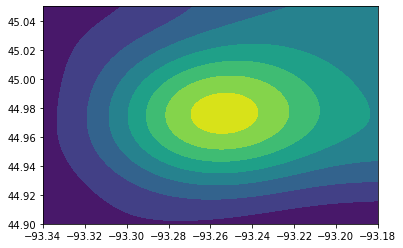

In [21]:
bounds_lat,bounds_lng = (44.9,45.05),(-93.34,-93.18)
hdx,hdy = [*zip(*df_pdfly.latlong)][::-1]
hdx,hdy = np.array(hdx),np.array(hdy)
sns.kdeplot(hdx,hdy,clip=(bounds_lng,bounds_lat),shade=True,cmap='viridis');

In [22]:
high_dens = df_pdfly.latlong[df_pdfly.latlong.str[0].round(2).between(*bounds_lat) & df_pdfly.latlong.str[1].round(2).between(*bounds_lng)]

In [229]:
here=Here(config.HERE_APPID, config.HERE_APPCODE)
high_dens_dists = []
partgrps = partition_groups(high_dens, max_group_size=100)
for o in high_dens.values:
    for grp in partgrps:
        fgrp = grp[~grp.apply(coord_strcomp,x2=o)].values
        high_dens_dists.append((o,fgrp,here.distance(o, fgrp)['response']['matrixEntry']))
pickle.dump(high_dens_dists, open('data/unused_interim/high_density_heredist.pkl','wb'))
hdens_dicts = [{'orig':o, 'dest':dests[d['destinationIndex']], **d['summary']
 } for o, dests, dat in high_dens_dists for d in dat]

In [259]:
df_hddist = pd.DataFrame(hdens_dicts)
hd_o2d = [geodesic_weight(o,d) for o,d in tqdm(df_hddist[['orig','dest']].values)]
df_hddist['geodesic_o2d'] = hd_o2d
df_hddist.to_pickle('data/hddist_df.pkl')

### Regression Models

In [464]:
df_data = pd.concat([df_hddist,df_fdist_nb],sort=False).reset_index(drop=True)
df_data['olat'] = df_data.origin_ll.str[0]
df_data['olng'] = df_data.origin_ll.str[1]
df_data['dlat'] = df_data.dest_ll.str[0]
df_data['dlng'] = df_data.dest_ll.str[1]

In [465]:
dfd = df_data.drop(columns=['origin_ll','dest_ll','distance','costFactor'])
dfd = dfd.join(dfd.pop('geodesic_o2d'))
X,y = dfd.iloc[:, 1:], dfd.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [466]:
rfr = RandomForestRegressor(100,n_jobs=-1).fit(X_train,y_train)
ypreds = rfr.predict(X_test)
pickle.dump(rfr,open('models/rf_regr.model','wb'))
r2_score(y_test,ypreds)

0.9808614902221902

In [275]:
data_xy = df_data[['geodesic_o2d','travelTime']].sort_values('geodesic_o2d')
data_xy = data_xy[data_xy['travelTime'] > 50]
#data_xy = data_xy[data_xy.geodesic_o2d < 22000]

X,y = data_xy.iloc[:,0].values.reshape(-1,1),data_xy.iloc[:,1]
Xsq,ysq = np.sqrt(data_xy.iloc[:,0]).values.reshape(-1,1), np.sqrt(data_xy.iloc[:,1])
Xl,yl = np.log(data_xy.iloc[:,0]).values.reshape(-1,1), np.log(data_xy.iloc[:,1])

X1sq = np.hstack([Xsq, np.ones_like(Xsq)])
X1l = np.hstack([Xl, np.ones_like(Xl)])

lrsq = LinearRegression(fit_intercept=False).fit(X1sq,ysq)
lrl = LinearRegression(fit_intercept=False).fit(X1l,yl)

lrsq.score(X1sq,ysq), lrl.score(X1l,yl) # (0.9526346195819283, 0.9474578241037097)

(0.810954547800737, 0.8303248721223381)

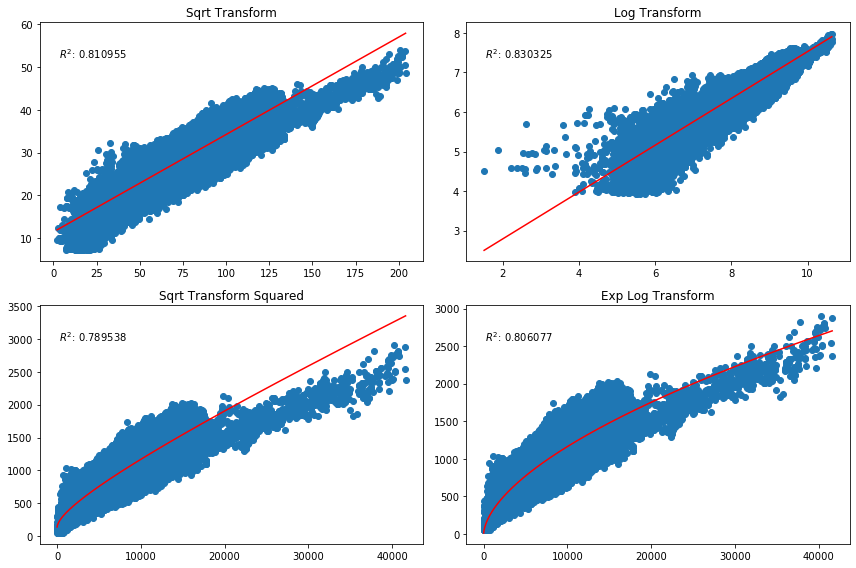

In [276]:
def plot_lr_tsfms(txtpos=(.05,.85)):
    fig, axes = plt.subplots(2,2, figsize=(12,8))
    axes[0,0].scatter(Xsq, ysq)
    axes[0,0].plot(Xsq, X1sq@lrsq.coef_, 'r')
    axes[0,0].annotate(f'$R^2$: {lrsq.score(X1sq,ysq):.6f}',txtpos,xycoords='axes fraction')
    axes[0,0].set_title('Sqrt Transform')

    axes[0,1].scatter(Xl, yl)
    axes[0,1].plot(Xl, X1l@lrl.coef_, 'r')
    axes[0,1].annotate(f'$R^2$: {lrl.score(X1l,yl):.6f}',txtpos,xycoords='axes fraction')
    axes[0,1].set_title('Log Transform');

    axes[1,0].scatter(np.square(Xsq), np.square(ysq))
    axes[1,0].plot(np.square(Xsq), np.square(X1sq@lrsq.coef_), 'r')
    axes[1,0].annotate(f'$R^2$: {r2_score(np.square(ysq),np.square(X1sq@lrsq.coef_)):.6f}',txtpos,xycoords='axes fraction')
    axes[1,0].set_title('Sqrt Transform Squared')

    axes[1,1].scatter(np.exp(Xl), np.exp(yl))
    axes[1,1].plot(np.exp(Xl), np.exp(X1l@lrl.coef_), 'r')
    axes[1,1].annotate(f'$R^2$: {r2_score(np.exp(yl),np.exp(X1l@lrl.coef_)):.6f}',txtpos,xycoords='axes fraction')
    axes[1,1].set_title('Exp Log Transform');
    plt.tight_layout()
plot_lr_tsfms()

In [23]:
'R^2 100 Shortest Dists- Sqrt: {:.6f}, Log: {:.6f}'.format(lrsq.score(X1sq[:100],ysq[:100]),lrl.score(X1l[:100],yl[:100]))

'R^2 100 Shortest Dists- Sqrt: 0.668716, Log: 0.856448'

Although the square root transform leads to an overall better $R^2$, it appears that the log transform better fits smaller distance values. Since we will quite often be calculating within a small radius, we'll move forward with this transform. 

If we wanted to create a better performing model while adding minimal complexity, we could train multiple linear regressors on various segments of the data and use a rule based approach.

### Weighting Functions

In [23]:
def geod_to_travel(xdist,tsfm='log'):
    if tsfm =='log':
        pred= np.exp(np.array([np.log(xdist),1.0])@lrl.coef_)
    else:
        pred = np.square(np.array([np.square(xdist),1.0])@lrsq.coef_)
    return pred

In [24]:
def gtsec_weight(orig,dest):
    return round(geod_to_travel(geodesic_weight(orig,dest)),4)

In [19]:
rfr = pickle.load(open('models/rf_regr.model','rb'))

In [26]:
def gtsec_weightrf(origin,dest,regr=None):
    regr = rfr if regr is None else regr
    xdat = np.array([*origin, *dest, geodesic_weight(origin,dest)],ndmin=2)
    return regr.predict(xdat)[0]

In [20]:
def form_edges(edges):
    return np.array([[*u,*v,geodesic_weight(u,v)] for u,v in edges])

In [21]:
def weight_edges(Gedg,regr=None):
    edges = Gedg.edges if isinstance(Gedg,nx.Graph) else Gedg 
    regr = rfr if regr is None else regr
    return [(u,v,round(w,4)) for (u,v),w in zip(edges,regr.predict(form_edges(edges)))]

### Complete Graph

In [22]:
def coord_to(coord, to='global_code', df=df_pdfly, nf_fill='ORIGIN'):
    mask = df.apply(lambda x: coord_strcomp(x['latlong'],coord),axis=1)
    compl = df[mask][to]
    len_compl = len(compl)
    return compl.iloc[0] if len_compl == 1 else (nf_fill if len_compl == 0 else compl)

In [23]:
# https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
cm_GrYlOrRd = mpl.colors.LinearSegmentedColormap.from_list('GrYlOrRd',np.vstack((plt.cm.YlGn_r(np.linspace(0.,1,128)),plt.cm.YlOrRd(np.linspace(0,1,128)))))
def color_edges(G,weight='weight',thresh=[.25,.50,.75], colors=['green','yellow','orange','red']):
    if isinstance(thresh[0],float):
        thresh = np.quantile([w for _,_,w in G.edges.data(weight)],thresh)
        nx.get_edge_attributes(CG,'weight').values()
    edgecols = [colors[0] if w < thresh[0] else 
                (colors[1] if w < thresh[1] else 
                 (colors[2] if w < thresh[2] else colors[3])) 
                for _,_,w in G.edges.data(weight)]
    return edgecols

In [24]:
def plot_cgraph(G, layout=nx.spring_layout, seed=None, noderelab=None, edgcol_thresh=[.25,.50,.75], edgelist=None, figsize=(8,8)):
    fig,ax = plt.subplots(figsize=figsize)
    pos_sl=layout if isinstance(layout, dict) else layout(G) if seed is None else layout(G,seed=seed)
    
    nodecols = ['green' if u == SOURCE else 'blue' for u in G.nodes]
    edgecols = color_edges(G, thresh=edgcol_thresh)
    nodelabs = {n:coord_to(n,noderelab) for n in G.nodes} if noderelab is not None else None

    nx.draw_networkx_nodes(G, pos=pos_sl, ax=ax, node_color=nodecols)
    nx.draw_networkx_edges(G, pos=pos_sl, ax=ax, edge_color=edgecols, edgelist=edgelist)
    nx.draw_networkx_labels(G,pos=pos_sl, ax=ax, labels=nodelabs, font_size=10, font_color='k')
    plt.axis('off')
    plt.tight_layout()

In [25]:
def plot_map(G,tour_coords):
    optcoords = np.array(tour_coords)
    pldf = pd.DataFrame(G.nodes,columns=['lat','lon']).assign(
    tourpoint=lambda x: x.apply(lambda x: 'include' if [x.lat,x.lon] in optcoords else 'exclude', axis=1))
    return px.scatter_geo(pldf,lat='lat',lon='lon',color='tourpoint',scope='usa')

In [26]:
def path_cost(G, path, path2edges=False, dwell_time=5*60):
    """Returns: total path cost, original path or edge path"""
    
    edge_path = [(p0,p1,G[p0][p1]['weight']+dwell_time) for p0,p1 in nx.utils.pairwise(path)]
    pweight = sum(p[2] for p in edge_path)
    return pweight, edge_path if path2edges else path

In [182]:
CG = nx.Graph()
CG.add_nodes_from([n, {'Pbb':d}] for n,d in G.nodes('prob_bb'))
CG.add_weighted_edges_from(edge_prefilter(CG.nodes))
CG.add_weighted_edges_from(edge_prefilter(CG.nodes, SOURCE))

## Adaptive Heuristic

https://arxiv.org/pdf/1906.07754.pdf

**Algorithm 1:** Adaptive heuristic for the Constrained Least-cost Cycle Problem

Suurballe and Tarjan’s algorithm at most n = |V(G)|

**input:** 
```
An undirected graph G with edge weights w : E(G) → ℕ and edge costs c : E(G) → ℕ;
the origin s* ∈ V(G); 
lower and upper weight thresholds W₁, W₂ ∈ ℕ.
```

1. Construct a directed, asymmetric graph (G') from the undirected graph G.
    * [build_auxiliary_node_connectivity](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.utils.build_auxiliary_node_connectivity.html?highlight=build%20aux#networkx.algorithms.connectivity.utils.build_auxiliary_node_connectivity)
2. For every pair of vertices u, v ∈ V(G'), compute the least-cost pair of vertex-disjoint paths ∆(u, v) between u and v.
    * [node_disjoint_paths](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.disjoint_paths.node_disjoint_paths.html)
3. From ∆(u, v), construct a simple cycle C. If s* ∈ C, then C is a candidate solution.
    * [simple_cycles](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html?highlight=simple%20cycle)

**output:** The least-cost weight-feasible simple cycle C* from all candidate solutions C.


**Components**

Given an input graph $G$, we construct a graph $G'$ 
by splitting each vertex $v$ of $G$ into two vertices $v_1$ and $v_2$ 
joined by an edge ($v_1$, $v_2$) of length zero. An edge ($v$, $w$)
of G becomes an edge ($v_2$, $w_1$) of $G$

----

In the CLT/CLC problem, we are given an undirected graph $G$ with vertices $V(G)$ and edges $E(G)$.
Edges have a weight function $w : E(G) \rightarrow N$ and a cost function $c : E(G) \rightarrow N$. 

However, Suurballe’s algorithm requires a directed input graph that is asymmetric, that is if $(x, y)$ is an arc in
the graph, then $(y, x)$ is not  in the graph.

We construct a directed, asymmetric graph $G'$ from the undirected graph G as follows. 
* For each vertex $v \in V(G)$, split $v$ into two vertices $v_1$ and $v_2$ and add them to $V(G')$. 
* Add a directed split arc from $v_1$ to $v_2$ in $G'$ with zero cost and zero weight. For every undirected edge $e_{u,v}$ adjacent to $v$ in $G$,
* add a directed arc from $v_2$ to $u_1$ in $G'$ with the same weight and cost as $e_{u,v}$ in $G$. 

The construction requires O(m + n) time and space complexity.

In [27]:
def n_permcomb(n,r=2,comb=True):
    return np.math.factorial(n)/(np.math.factorial(r if comb else 1)*np.math.factorial(n-r))

In [28]:
def pretrim_edges(nodes, source=None, max_weight=25*60):
    combs = itertools.combinations(nodes,2) if source is None else itertools.product([source], nodes)
    return [(u,v,w) for u,v,w in weight_edges([*combs]) if w < max_weight] 

In [29]:
def trim_edges(G, max_weight=25*60, weight='weight', **kwargs):
    G.remove_edges_from([(u,v) for u,v,w in G.edges.data(weight) if w > max_weight])
    return G

def trim_degree(G, min_degree=1, **kwargs):
    rm_nodes = [n for n,deg in G.degree if deg < min_degree]
    G.remove_nodes_from(rm_nodes)
    return G

def trim_graph(CG, source=SOURCE, budget=BUDGET, plot=True, noderelab=None, **kwargs):
    mst_CG = nx.tree.minimum_spanning_tree(CG,algorithm='kruskal')#boruvka
    tpaths = [nx.shortest_path(mst_CG,source=source,target=n,weight='weight') for n in mst_CG.nodes if n != source]
    for G in [CG,mst_CG]:
        G.remove_nodes_from([path[-1] for cost,path in [path_cost(mst_CG,p) for p in tpaths] if cost > budget/2])
    if plot:
        plot_cgraph(mst_CG, figsize=(8,8), noderelab=noderelab)
    return CG

def full_trim(G, source=None, budget=BUDGET, verbose=False, **kwargs):
    if verbose: print(nx.info(G))
    G = trim_graph(G,source=source, budget=budget, **kwargs)
    if verbose: print(nx.info(G))
    G = trim_edges(G, **kwargs)
    if verbose: print(nx.info(G))
    G = trim_degree(G,**kwargs)
    if verbose: print(nx.info(G))
    return G

In [30]:
def is_asymmetric(Gedg=None):
    edges = Gedg.edges if isinstance(Gedg,nx.Graph) else Gedg   
    symedges = [((u,v),(v,u)) for u,v in edges if (v,u) in edges]
    return (False,symedges) if any(symedges) else True

In [31]:
def mxln_mncost(cost_paths):
    mxln = max([len(path) for cost,path in cost_paths])
    opth = min(filter(lambda p: len(p[1]) == mxln, cost_paths),key=lambda c: c[0])
    return opth

In [32]:
def adaptive_heuristic(CG, source=SOURCE, min_weight=None, max_weight=BUDGET):
    A = nx.connectivity.build_auxiliary_node_connectivity(CG)
    R = nx.flow.build_residual_network(A,'capacity')
    flowfn = nx.flow.shortest_augmenting_path # O(n²m) instead of O(nm²) where ,n=nodes,m=edges
    djpaths = [[*nx.node_disjoint_paths(CG,u,v,flow_func=flowfn, auxiliary=A,residual=R)] for u,v in CG.edges]

    djp_costs = [[path_cost(CG,p, True) for p in d] for d in djpaths]
    mintoplen = [mxln_mncost(djc)[1] for djc in djp_costs]
    
    Gdi = nx.DiGraph()
    Gdi.add_weighted_edges_from([(u,v,w) for wdp in mintoplen for u,v,w in wdp])

    cyc_Gdi = [x for x in tqdm(nx.simple_cycles(Gdi))]
    scyc_Gdi = [c for c in cyc_Gdi if source in c] # only consider paths that include source
    # Filter out paths that exceed budget
    pcos = [cpath for cpath in [path_cost(Gdi,p) for p in scyc_Gdi] if cpath[0] < max_weight]
    # Maximize visited locations
    opt_paths = sorted(pcos, key=lambda p: len(p[1]), reverse=True)
    opath = mxln_mncost(opt_paths)
    
    plot_cgraph(Gdi, nx.shell_layout(Gdi,[Gdi.nodes^opath[1], opath[1]]),noderelab='place_name', edgelist=[*nx.utils.pairwise(opath[1])])
    return Gdi,opt_paths

In [33]:
CG = nx.complete_graph([SOURCE]+sorted(G.nodes,key=lambda x: G.nodes[x]['distCW']), nx.Graph)
CG.add_weighted_edges_from(weight_edges(CG))
CGt = trim_graph(CG.copy(),source=SOURCE, budget=BUDGET, plot=False)
#CGt = full_trim(CG.copy(), source=SOURCE, verbose=False, plot=False)
CGi = nx.relabel_nodes(CG,ll_idx); CGi.name = 'complete_graph_index_trimmed'
CGit = trim_graph(CGi.copy(),source=0, budget=BUDGET, plot=False)
print(nx.info(CGit))

Name: complete_graph_index_trimmed
Type: Graph
Number of nodes: 47
Number of edges: 1081
Average degree:  46.0000


In [41]:
Gdi,opt_paths = adaptive_heuristic(CGt, SOURCE, max_weight=BUDGET)

In [45]:
plot_map(Gdi,opt_paths[0][1])

In [70]:
#Gi_samp = Gi.subgraph([*Gi.nodes][:n]).copy()
#snodes = Gi_samp.nodes
#xsmp = [Gi_samp.get_edge_data(u,v,{'weight':0})['weight'] for u,v in itertools.product(snodes,repeat=2)]
#cost_matrix = np.array(xsmp,dtype=dtype).reshape((n,n))
#np.fill_diagonal(cost_matrix,1e4)
#cost_matrix += dwell_time

# for i in range(n_nodes): constraints.append(cx.sum(x[:,i])==cx.sum(x[i,:]))
#constraints.append((cx.sum((u[perm]*[1,-1]),axis=1)+(x*n_nodes)[perm[:,0],perm[:,1]] <= n_nodes-1))
#c1 = cx.sum(u[perm]*np.array([1,-1]),axis=1)
#c1 = u[p0]-u[p1]
#c2 = (x*n_nodes)[p0,p1]
    
#for i,j in itertools.permutations(range(1,n_nodes),2):
    #constraints.append((u[i]-u[j]+n_nodes*x[i,j]<=n_nodes-1))
    #constraints.append((u[i]-u[j]+n_nodes*x[i,j]-n_nodes+1<=0))

In [74]:
def samp_init(Gi, nodelist=None, n=None, dwell_time=0, dtype=None, score_mult=100, validate_edges=True, nonedge=None):
    if nodelist is not None:
        n,snodes= len(nodelist), nodelist
    elif n is not None:
        n,snodes= n,[*Gi.nodes][:n]
    else:
        n,snodes= Gi.number_of_nodes(), Gi.nodes
    nonedge = nonedge if nonedge is not None else 0.0
    cost_matrix = (nx.to_numpy_array(Gi,snodes,dtype=dtype, nonedge=nonedge)+np.diag([1e6]*n))+dwell_time
    if validate_edges:
        if np.any(cost_matrix == 0):
            raise ArithmeticError(
                'Non-existent (0 Cost) edges found. Bypass check with validate_edges=False and specify nonedge value')
    score_vector = np.round([idx2prob[n]*score_mult for n in snodes],2)
    score_vector[0]=0
    if dtype is not None:
        score_vector = score_vector.astype(dtype)
    
    return cost_matrix,score_vector,snodes

If the travel cost allows the selection of half of the customers,
the highest number of non-dominated selections will have to be evaluated by the
algorithm. Moreover, determining the TSP route between the selected customers
becomes more complicated when the number of customers increases. Therefore,
the most difficult OP to solve by any kind of enumeration technique, are those
problems where the selected number of customers is a little more than half the
total number of customers.

In [75]:
def cvx_solve(cost_matrix, score_vector, budget):
    nnodes=len(score_vector)
    x=cx.Variable((nnodes,nnodes),name='x',boolean=True) # x_ij is 1, if we travel from i to j in the tour.
    u=cx.Variable(nnodes,name='u') # variables in subtour elimination constraints

    cost=cx.trace(cx.matmul(cost_matrix.T,x)) #total cost of the tour
    profit=cx.sum(cx.matmul(x,score_vector))

    ones_arr=np.ones([nnodes])
    perm = np.array([*itertools.permutations(np.arange(1,nnodes),2)])
    p0,p1 = perm[:,0], perm[:,1]

    constraints=[]

    # make sure each node is visited only once, and we leave only once from that node.
    constraints.append(cx.sum(x[0,:])==1) # route starts on first node
    constraints.append(cx.sum(x[:,0])==1) # route ends on first node
    
    out_con = cx.matmul(x.T,ones_arr) #cx.sum(x,axis=1)
    in_con = cx.matmul(x,ones_arr) #cx.sum(x,axis=0)
    constraints.append(out_con<=1) # max one outgoing connection
    constraints.append(in_con<=1) # max one incoming 
    constraints.append(in_con==out_con)
    
    constraints.append(cost<=budget) # add the time constraints
     
    # subtour elimination constraints (Miller-Tucker-Zemlin formulation)
    constraints.append(u[p0]-u[p1]+x[p0,p1]*nnodes - nnodes+1 <= 0)
    #constraints.append(u[p0]-u[p1]+1 <= (nnodes-1)*(1-x[p0,p1]))

    prob=cx.Problem(cx.Maximize(profit),constraints)
    st=time.time()
    prob.solve()#solver=cx.GLPK_MI
    prob.solver_stats.solve_time = time.time()-st
    
    if np.any(x.value==None): # no feasible solution found
        print('Feasible solution not found, increase budget allotment') 
    
    return prob, cost

In [76]:
def tour_path(x, score_vector, cost_matrix):
    # build tour path and tour cost independent from solver.
    tour=[0] # Initialize with source node.
    
    verified_cost=0 
    nnodes = x.shape[0]
    
    G=nx.DiGraph()
    G.add_nodes_from([(k+1,{'value':score_vector[k]}) for k in range(nnodes)])
    
    cur_node, next_node = 0, -1 #Initialize at start node
    while(next_node != 0): # until end node reached
        next_node=np.argmax(x.value[cur_node,:]) # where we go from node i
        G.add_edge(cur_node+1,next_node+1,weight=int(cost_matrix[cur_node,next_node])) # 1 based indexing graph
        verified_cost+=cost_matrix[cur_node,next_node] # build up the cost
        tour.append(next_node) # for 1 based indexing
        cur_node=next_node

    return G, tour, verified_cost

In [77]:
def plot_opnodes(G, nodes, budget):
    fig,ax = plt.subplots(figsize=(8,7))
    color_map=['green']+['red']*(len(nodes)-1)
    pos = nx.circular_layout(G)
    nodelabs={a:n for a,n in zip(G.nodes,nodes)}
    nodesize = np.array([*nx.get_node_attributes(G,'value').values()])
    nodesize = (nodesize-nodesize.min())/nodesize.ptp()
    nodesize[0] = 1
    edgelabs=nx.get_edge_attributes(G,'weight')
    gposax = dict(G=G,pos=pos,ax=ax)
    
    nx.draw_networkx_nodes(node_size=nodesize*750, node_color=color_map, **gposax)
    nx.draw_networkx_edges(width=1.0, edge_color='k', **gposax)

    nx.draw_networkx_labels(labels=nodelabs, font_size=8, font_color='k', **gposax)
    nx.draw_networkx_edge_labels(edge_labels=edgelabs, **gposax)
    
    ax.set_title('Budget {}'.format(budget))
    plt.axis('off')
    plt.show()

In [78]:
def orienteer(CGi, nodelist=None, n_nodes=None, budget=BUDGET, dtype=None, score_mult=100):
    cost_matrix,score_vector,nodes = samp_init(CGi, nodelist=nodelist, n=n_nodes, dtype=dtype,score_mult=score_mult)

    prob,cost = cvx_solve(cost_matrix,score_vector,budget)
    (x,u),profit = prob.variables(),prob.value

    g, tour, verified_cost = tour_path(x, score_vector, cost_matrix)
    
    node_tour = np.array(nodes)[tour]
    print('Maximum Profit Tour:')
    print(*node_tour,sep=' -> ')
    print('Tour Profit: {}, Cost: {}, Cost (verifiy): {}'.format(*np.round([prob.value,cost.value,verified_cost],2)))
    print('Solve Time: {:0.2f} secs'.format(prob.solver_stats.solve_time))
    plot_opnodes(g,nodes,budget)
    return g,prob,node_tour

In [82]:
mm_solvetime = []
for i in tqdm(range(15,20)):
    x_cost,x_score,x_snodes = samp_init(CGit,n=i,score_mult=1000)
    tprob, tcost = cvx_solve(x_cost,x_score,BUDGET)
    (tx, tu), tprofit = tprob.variables(),tprob.value
    xG,xpth,xvcost = tour_path(tx,x_score,x_cost)
    st = tprob.solver_stats.solve_time
    mm_solvetime.append(st)
    print('solve time: {:0.4f} s | i: {}, pathlen: {} | cost: {:0.2f} | profit: {:0.2f}'.format(st, i, len(xpth), tcost.value, tprofit))
    print(xpth)
    print()
print(sum(mm_solvetime))

solve time: 0.0350 s | i: 15, pathlen: 16 | cost: 11401.23 | profit: 2900.00
[0, 3, 9, 6, 7, 13, 12, 10, 8, 4, 1, 2, 5, 11, 14, 0]

solve time: 0.0300 s | i: 16, pathlen: 17 | cost: 11372.32 | profit: 3000.00
[0, 1, 2, 6, 9, 12, 5, 4, 11, 3, 7, 8, 10, 13, 14, 15, 0]

solve time: 0.0420 s | i: 17, pathlen: 18 | cost: 13890.34 | profit: 3100.00
[0, 5, 9, 10, 8, 15, 14, 11, 12, 4, 1, 2, 3, 6, 13, 7, 16, 0]

solve time: 0.0380 s | i: 18, pathlen: 19 | cost: 14375.11 | profit: 3200.00
[0, 3, 15, 14, 11, 10, 8, 7, 13, 4, 1, 2, 12, 9, 16, 5, 6, 17, 0]

solve time: 0.1220 s | i: 19, pathlen: 20 | cost: 15544.06 | profit: 3563.64
[0, 3, 4, 1, 2, 18, 16, 12, 10, 5, 15, 14, 11, 8, 7, 13, 9, 17, 6, 0]


0.26703786849975586


In [97]:
x_cost,x_score,x_snodes = samp_init(CGit,score_mult=100) # 33 finished in 26s
tprob, tcost = cvx_solve(x_cost,x_score,BUDGET)
(tx, tu), tprofit = tprob.variables(),tprob.value
xG,xpth,xvcost = tour_path(tx,x_score,x_cost)
st = tprob.solver_stats.solve_time
print('solve time: {:0.4f} s | pathlen: {} | cost: {:0.2f} | profit: {:0.2f}'.format(st, len(xpth), tcost.value, tprofit))
print(xpth)

solve time: 0.3500 s | pathlen: 27 | cost: 17890.52 | profit: 426.36
[0, 1, 5, 2, 3, 4, 13, 12, 18, 14, 15, 16, 22, 23, 21, 20, 19, 17, 9, 6, 25, 10, 24, 11, 8, 7, 0]


In [85]:
path_cost(CGit,np.array(CGit.nodes)[xpth], dwell_time=0)

(17752.699999999997,
 array([   0, 1110, 1083,  986, 1044, 1049,  524, 1963,  372,  376,  983,
         337, 1035,  826,  781,  639,  431,  723,  404,  648,  398, 1699,
         470, 1032,  828, 1105,    0]))

In [88]:
# Minor adaptation from https://github.com/BraveDistribution/pytsp/blob/master/pytsp/christofides_tsp.py
def christofides(G, starting_node=0):
    """
    Christofides TSP algorithm
    http://www.dtic.mil/dtic/tr/fulltext/u2/a025602.pdf
    Args:
        G: undirected networkX Graph
        starting_node: of the TSP
    Returns:
        indices of tour nodes given by christofies TSP algorithm
    """
    Gmst = nx.minimum_spanning_tree(G,algorithm='prim')
    graph = nx.to_numpy_array(G)
    mst = nx.to_numpy_array(Gmst)

    odd_degree_nodes = np.nonzero(np.array([d for _,d in Gmst.degree]) % 2 !=0)[0]
    odd_degree_nodes_ix = np.ix_(odd_degree_nodes, odd_degree_nodes)
    nx_graph = nx.from_numpy_array(-1 * graph[odd_degree_nodes_ix])
    matching = nx.max_weight_matching(nx_graph, maxcardinality=True)
    euler_multigraph = nx.MultiGraph(mst)
    for u,v in matching:
        euler_multigraph.add_edge(odd_degree_nodes[u], odd_degree_nodes[v],
                                  weight=graph[odd_degree_nodes[u]][odd_degree_nodes[v]])
    euler_tour = list(nx.eulerian_circuit(euler_multigraph, source=starting_node))
    path = list(itertools.chain.from_iterable(euler_tour))
    return list(dict.fromkeys(path).keys())# drop repeated nodes # +[starting_node])[:-1] , append starting node

In [93]:
chttour = np.array(CGit)[christofides(CGit)]
chtpc = np.array(path_cost(CGit,chttour,True,0)[1])
sum([idx2prob[v] for v in chtpc[chtpc[:,2].cumsum(axis=0) < BUDGET][:,1]])

4.263636363636365

Maximum Profit Tour:
0 -> 1110 -> 1083 -> 986 -> 1044 -> 1049 -> 524 -> 1963 -> 372 -> 376 -> 983 -> 337 -> 1035 -> 826 -> 781 -> 639 -> 431 -> 723 -> 404 -> 648 -> 398 -> 1699 -> 470 -> 1032 -> 828 -> 1105 -> 0
Tour Profit: 4263.64, Cost: 17752.7, Cost (verifiy): 17752.7
Solve Time: 1.42 secs


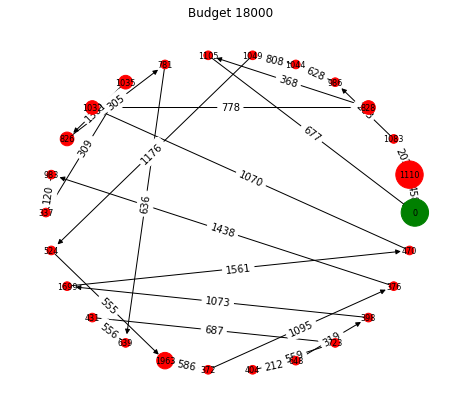

In [96]:
xG,xprb,xtour = orienteer(CGit,score_mult=100)

In [95]:
plot_map(CG,[idx_ll[t] for t in xtour])

## Misc Experiments

In [39]:
CGFt = full_trim(CG.copy(), source=SOURCE, verbose=False, plot=False)

In [193]:
def k_shortest_paths(G, source, target, k, weight='weight'):
    return list(itertools.islice(nx.shortest_simple_paths(G, source, target, weight=weight), k))

In [42]:
[*itertools.islice(nx.find_cliques(CGFt),1)]

[[(44.830566, -92.957949),
  (44.93849, -93.080782),
  (44.948139, -93.094544),
  (44.854162, -93.045382),
  (44.938234, -93.093455),
  (44.949188, -93.08916),
  (44.955548, -93.127877),
  (44.963963, -93.071135),
  (44.943143, -92.929925),
  (44.830604, -92.958049),
  (44.945434, -92.942019),
  (44.950735, -93.088588)]]

In [50]:
[*nx.centrality.current_flow_closeness_centrality(CGFt,weight='weight').items()][:5]

[((44.963963, -93.071135), 429.4247948802883),
 ((44.950735, -93.088588), 423.23077770865507),
 ((44.949188, -93.08916), 423.7100842468327),
 ((44.948139, -93.094544), 421.74081561228405),
 ((44.93849, -93.080782), 438.8474459242849)]

In [52]:
[*nx.centrality.edge_betweenness_centrality(CGFt,weight='weight').items()][:5]

[(((44.963963, -93.071135), (44.950735, -93.088588)), 0.0009250693802035153),
 (((44.963963, -93.071135), (44.949188, -93.08916)), 0.0009250693802035153),
 (((44.963963, -93.071135), (44.948139, -93.094544)), 0.0009250693802035153),
 (((44.963963, -93.071135), (44.93849, -93.080782)), 0.0009250693802035153),
 (((44.963963, -93.071135), (44.984178, -93.099486)), 0.002775208140610546)]

In [143]:
nx.average_degree_connectivity(TG,weight='weight')

{13: 12.296697750795154,
 12: 14.73837768478283,
 8: 13.417864598698914,
 24: 14.495883633510552,
 14: 15.673470868964143,
 9: 10.451382949263367,
 20: 14.44569702406241,
 15: 14.938180501688583,
 16: 15.435132901550304,
 18: 15.143699811263827,
 10: 11.025910053969163,
 4: 8.256199440983137,
 1: 2.400552579034984,
 7: 8.694840564980025,
 6: 10.03805811140156,
 3: 10.534011559009302}

In [54]:
[*nx.neighbor_degree.average_neighbor_degree(CGFt,weight='weight').items()][:5]

[((44.963963, -93.071135), 38.316800867159195),
 ((44.950735, -93.088588), 38.35066157669652),
 ((44.949188, -93.08916), 38.360740284628285),
 ((44.948139, -93.094544), 38.29706840715886),
 ((44.93849, -93.080782), 38.83787517052095)]

In [59]:
nx.voronoi_cells(CGFt,[SOURCE])

In [62]:
[*nx.coloring.greedy_color(CG).items()][:5]

[((44.963963, -93.071135), 0),
 ((44.950735, -93.088588), 1),
 ((44.949188, -93.08916), 2),
 ((44.948139, -93.094544), 3),
 ((44.93849, -93.080782), 4)]

## OSMNX

In [171]:
import osmnx as ox

In [132]:
here = Here(config.HERE_APPID, config.HERE_APPCODE)

In [238]:
malformed = df_pdfly[df_pdfly.dest_addr.str.split(', ').apply(len) < 3]
malformed.head(3)

place_name                  latlong  \
113                          Lake Maria State Park  [45.315063, -93.951519]   
2                             Otter Lane Book Shop  [45.197761, -93.388925]   
3    Enchantasys Lingerie & More Intimate Boutique  [45.219339, -93.423261]   

                              vicinity             dest_addr     keyword  \
113  11411 Clementa Ave NW, Monticello       ilver Creek, MN        park   
2                 208 E Main St, Anoka  208 E Main St, Anoka  book store   
3                   6111 US-10, Ramsey    6111 US-10, Ramsey  book store   

                                                 types  rating  n_ratings  \
113  [campground, tourist_attraction, lodging, park...     4.6      370.0   
2    [book_store, point_of_interest, store, establi...     0.0        0.0   
3    [book_store, electronics_store, home_goods_sto...     4.0       19.0   

                        place_id place_group    geodesic_m  travel_m  \
113  ChIJVZOc2gWatFIRpusOTu6RuGs   park_camp   1273.033027     80318   
2    ChIJ76xL-IM_s1IRAg42YKWDUSY    academic  36071.796110     11154   
3    ChIJzb-DIaU_s1IRv6LSGd3Cfcg    academic  39671.790927     13541   

     travel_secs                   origin  global_code  price_level  
113         3489  [45.317972, -93.935816]  86Q8828X+29          NaN  
2            921  [45.217293, -93.298682]  86Q85JX6+4C          NaN  
3            830  [45.217293, -93.298682]  86Q86H9G+PM          NaN

In [145]:
mal_rgeo = [gmaps.reverse_geocode(x) for x in malformed.latlong]
json.dump(mal_rgeo, open('data/json/rvgeocode_malform_pdfly.json', 'w'))

In [238]:
mal_rgeo = json.load(open('data/json/rvgeocode_malform_pdfly.json', 'r'))
mal_rvgeo_df = pd.concat([json_normalize(x[0]) for x in mal_rgeo], sort=False)

mal_rvgeo_df = mal_rvgeo_df.drop(mal_rvgeo_df.filter(regex='bounds|viewport|compound').columns,1).rename(lambda x: x.split('.')[-1], axis=1)
mal_rvgeo_df['formatted_address'] = mal_rvgeo_df.formatted_address.str.replace(', USA','')

cities = [x for x in map(lambda x: x.group() if x else None, [re.fullmatch(r'([A-Z][a-z]+ ?)+',x) for x in df_pdfly[df_pdfly.dest_addr.str.split(', ').apply(len) > 2].dest_addr.str.split(', ').str[-2].unique()]) if x]
cities.extend(mal_rvgeo_df.formatted_address.str.split(', ').str[-2].unique())
cities = list(set(cities))

gdf_cities = ox.gdf_from_places([f'{city}, MN, USA' for city in cities])
gdf_cities_proj = ox.project_gdf(gdf_cities)
gdf_cproj_poly = gdf_cities_proj[gdf_cities_proj.geom_type != 'LineString']
gdf_cities

geometry  \
0    POLYGON ((-92.862690 44.942863, -92.862658 44....   
1    POLYGON ((-93.016114 45.003734, -93.015064 45....   
2    POLYGON ((-92.651473 45.354021, -92.651411 45....   
3    POLYGON ((-93.081937 45.174609, -93.081926 45....   
4    POLYGON ((-93.399045 44.746527, -93.397408 44....   
..                                                 ...   
102  POLYGON ((-93.105933 44.883385, -93.099869 44....   
103  MULTIPOLYGON (((-93.861061 45.332818, -93.8591...   
104  POLYGON ((-94.261278 45.414168, -94.250287 45....   
105  POLYGON ((-93.188706 45.124374, -93.188645 45....   
106  POLYGON ((-93.065395 44.883556, -93.065318 44....   

                                            place_name  bbox_north  \
0    Afton, Washington County, Minnesota, 55001, Un...   44.949030   
1    North St. Paul, Ramsey County, Minnesota, Unit...   45.031909   
2       Dresser, Polk County, Wisconsin, United States   45.383027   
3    Centerville, Anoka County, Minnesota, United S...   45.174877   
4    Savage, Scott County, Minnesota, United States...   44.798763   
..                                                 ...         ...   
102  West Saint Paul, Dakota County, Minnesota, 551...   44.923287   
103  Monticello, Wright County, Minnesota, 55362-46...   45.338397   
104  St. Augusta, Stearns County, Minnesota, United...   45.492823   
105  Shoreview, Ramsey County, Minnesota, 55126, Un...   45.124378   
106  South Saint Paul, Dakota County, Minnesota, 55...   44.919527   

     bbox_south  bbox_east  bbox_west  
0     44.861857 -92.756672 -92.862690  
1     44.995718 -92.984702 -93.016114  
2     45.346256 -92.616095 -92.651473  
3     45.149355 -93.035264 -93.081937  
4     44.716939 -93.327689 -93.399045  
..          ...        ...        ...  
102   44.883353 -93.065166 -93.105933  
103   45.270526 -93.735025 -93.861061  
104   45.412967 -94.134747 -94.261278  
105   45.035764 -93.106214 -93.188706  
106   44.848196 -93.010076 -93.065395  

[107 rows x 6 columns]

In [24]:
lat_min_S, lat_max_N = df_pdfly.latlong.str[0].min(), df_pdfly.latlong.str[0].max()
lng_min_W, lng_max_E = df_pdfly.latlong.str[1].min(), df_pdfly.latlong.str[1].max()

In [28]:
# (South, West, North, East): min_lat, min_lng, max_lat, max_lng
lat_max_N,lat_min_S,lng_max_E,lng_min_W

(45.539975, 44.673566, -92.452544, -94.241201)

In [29]:
%%time
G1 = ox.graph_from_bbox(lat_max,lat_min,lng_max,lng_min, network_type='drive_service',simplify=False) #4m
G2 = G1.copy() #30s
ox.save_graphml(G1,filename='street_unsimp_bbox_fly.graphml',folder='data/geospatial') #1m45s
G2 = ox.simplify_graph(G2) # 3m
ox.save_graphml(G2,filename='street_simp_bbox_fly.graphml',folder='data/geospatial') #1m45s
G1 = ox.load_graphml('street_unsimp_bbox_fly.graphml',folder='data/geospatial') #?m
G1_proj = ox.project_graph(G1) #4m25
G1_proj = ox.simplify_graph(G1_proj) #3m
ox.save_graphml(G1_proj,filename='street_simpproj_bbox_fly.graphml',folder='data/geospatial') #1m45s

Wall time: 4min 4s



Note that if you want a projected network, it's usually faster for large cities to 
1. say simplify=False, 
2. then project the graph, 
3. then simplify it. 

Projecting a simplified graph with spatial geometries embedded as edge attributes can take a _long_ time in large networks.

In [33]:
G3 = ox.graph_from_bbox(lat_max,lat_min,lng_max,lng_min, network_type='drive',simplify=False) #3m30s
G3_proj = ox.project_graph(G3) #3m45s
G3_proj = ox.simplify_graph(G3_proj) #?
ox.save_graphml(G3_proj,filename='drive_simpproj_bbox_fly.graphml',folder='data/geospatial') #?

Wall time: 3min 35s


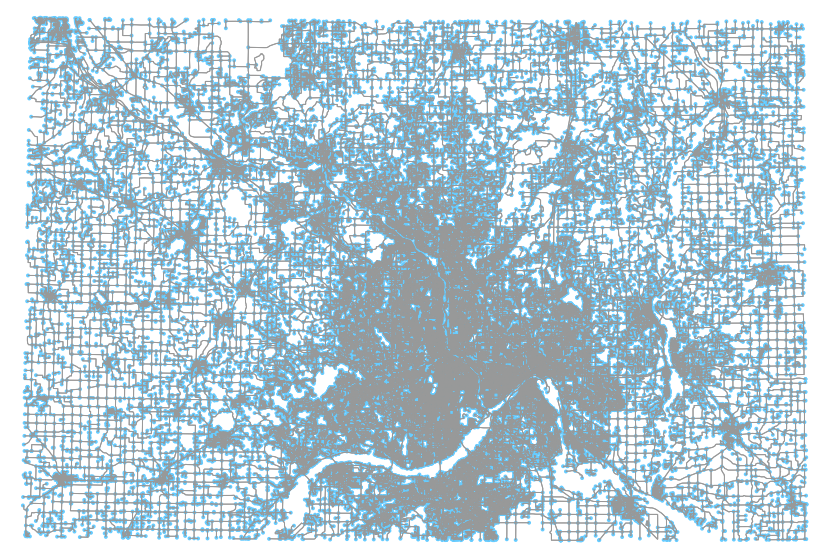

In [37]:
fig, ax = ox.plot_graph(G3_proj,fig_height=10)

In [240]:
%time W10k = ox.graph_from_point(config.geo.CENTERW,10000,network_type='drive',simplify=False)
%time W10k = ox.project_graph(W10k)
%time W10k = ox.simplify_graph(W10k)

Wall time: 17.8 s
Wall time: 17.8 s
Wall time: 11.6 s


In [243]:
ox.basic_stats(W10k)

{'n': 15587,
 'm': 42297,
 'k_avg': 5.427214986848014,
 'intersection_count': 13323,
 'streets_per_node_avg': 3.016616411111824,
 'streets_per_node_counts': {0: 0,
  1: 2264,
  2: 93,
  3: 8451,
  4: 4683,
  5: 91,
  6: 5},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.14524924616667736,
  2: 0.005966510553666517,
  3: 0.5421825880541477,
  4: 0.3004426765894656,
  5: 0.005838198498748957,
  6: 0.00032078013729389875},
 'edge_length_total': 6530355.726000038,
 'edge_length_avg': 154.39288190651908,
 'street_length_total': 3744657.0940000266,
 'street_length_avg': 158.74590249692767,
 'street_segments_count': 23589,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.7768667851410113e-05,
 'self_loop_proportion': 0.004231978627325815,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

In [52]:
graph_map = ox.plot_graph_folium(W10k)

In [54]:
graph_map.save('html_out/W10k_osmnx.html')

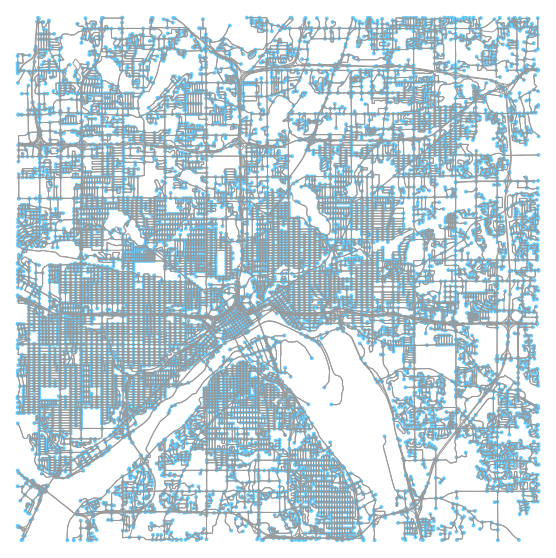

In [51]:
fig, ax = ox.plot_graph(W10k,fig_height=10, fig_width=10)

In [415]:
nx.draw_networkx_nodes(W10k, nx.layout.planar_layout()

15587

In [54]:
df_fdist[(df_fdist.dest_ll.str[1] < -92.9) & (df_fdist.geodesic_o2d < 42000)]

distance  travelTime  costFactor                  dest_ll  \
0        29552        1546        1626   [45.16309, -93.162149]   
1        26628        1458        1538  [45.136909, -93.168394]   
2        15544        1128        1188  [45.080704, -93.119467]   
3        26983        1759        1819  [45.125497, -93.256891]   
4        15830        1066        1126  [45.053073, -93.148589]   
...        ...         ...         ...                      ...   
1964      5627         628         668   [44.95913, -93.126742]   
1965     14969        1207        1247   [44.97528, -93.236225]   
1966      6808         657         697  [45.001593, -93.077409]   
1967     14961        1237        1277  [44.971172, -93.233449]   
1968     14458        1107        1147  [44.969975, -93.232177]   

                    origin_ll  geodesic_o2d  
0     [44.963963, -93.071135]  23261.595979  
1     [44.963963, -93.071135]  20690.834515  
2     [44.963963, -93.071135]  13521.375951  
3     [44.963963, -93.071135]  23161.226733  
4     [44.963963, -93.071135]  11634.137849  
...                       ...           ...  
1964  [44.963963, -93.071135]   4420.120644  
1965  [44.963963, -93.071135]  13084.282691  
1966  [44.963963, -93.071135]   4211.050671  
1967  [44.963963, -93.071135]  12830.197948  
1968  [44.963963, -93.071135]  12722.498628  

[1858 rows x 6 columns]

In [399]:
cpoints = np.vstack(df_fdist[(df_fdist.dest_ll.str[1] < -92.9) & (df_fdist.geodesic_o2d < 42000)].dest_ll.values)

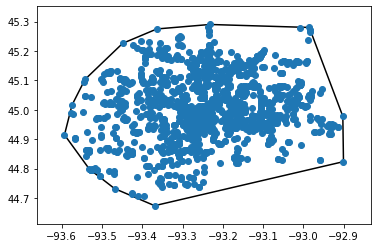

In [400]:
points = cpoints[:,::-1]
hull = sp.spatial.ConvexHull(points)
sp.spatial.convex_hull_plot_2d(hull);

In [401]:
polybb = shapely.geometry.Polygon(points[hull.vertices])

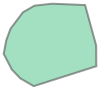

In [404]:
polybb = ox.round_polygon_coords(polybb,3); polybb

In [405]:
Gpoly = ox.graph_from_polygon(polybb,'drive',simplify=False,name='metro_points')

In [406]:
Gpoly = ox.project_graph(Gpoly)
Gpoly = ox.simplify_graph(Gpoly)

In [408]:
ox.save_graphml(Gpoly,filename='drive_simpproj_poly_fly.graphml',folder='data/geospatial')

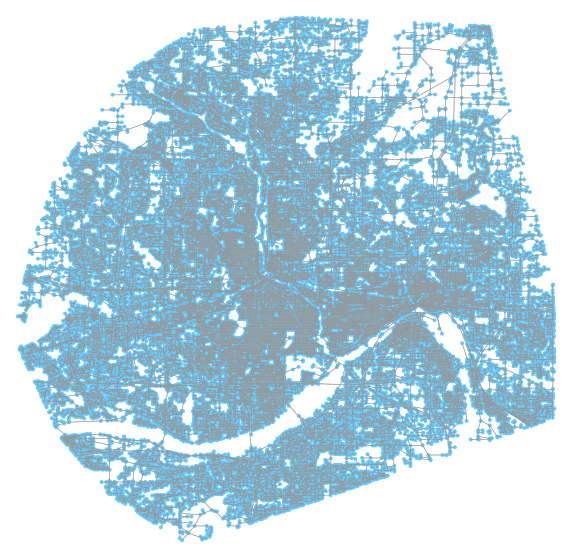

In [413]:
fig,ax = ox.plot_graph(Gpoly,fig_height=10, fig_width=10,edge_linewidth=.6,edge_alpha=.8,use_geom=False)

In [258]:
Gpoly = ox.load_graphml(filename='drive_simpproj_poly_fly.graphml',folder='data/geospatial')

In [302]:
np.array(CG.nodes)[:,0]

array([45.152711, 45.107264, 44.962394, 45.137095, 45.167371, 45.010581,
       45.086879, 44.939835, 45.178299, 45.109662, 45.044056, 44.969137,
       45.046842, 45.197978, 45.036266, 45.162732, 45.0416  , 44.974183,
       44.971718, 44.84438 , 44.767016, 44.93716 , 44.921735, 44.966302,
       44.946983, 45.168664, 45.196274, 45.211525, 44.879671, 44.765477,
       44.934096, 44.939666, 45.022505, 45.163239, 45.178811, 44.959757,
       45.057813, 45.101539, 45.090204, 45.083766, 44.954295, 44.95696 ,
       44.925014, 45.142996, 44.923118, 45.1097  , 45.132642, 44.940249,
       44.83441 , 44.964322, 44.963963])

In [318]:
[*itertools.islice(Gpoly.nodes(data=True),1)]

[(2657091855,
  {'y': 4976078.410368689,
   'x': 506367.20645183214,
   'osmid': 2657091855,
   'highway': 'traffic_signals',
   'ref': 'nan',
   'lon': '-92.9193004',
   'lat': '44.93811'})]

In [319]:
np.array(CG.nodes)[0]

array([ 45.152711, -93.16219 ])

In [324]:
coord_to(np.array(CG.nodes)[0],'place_name')

'Living Faith Church'

In [325]:
ox.get_nearest_node(Gpoly,np.array(CG.nodes)[0],return_dist=True)

(188515389, 32836.37589971782)

In [323]:
Gpoly.nodes(data=True)[ox.get_nearest_node(Gpoly,np.array(CG.nodes)[0])]

{'y': 4947353.081060564,
 'x': 470162.8243636092,
 'osmid': 188063754,
 'highway': 'nan',
 'ref': 'nan',
 'lon': '-93.3764742',
 'lat': '44.678926'}

In [313]:
nnodes = ox.get_nearest_node(Gpoly,np.array(CG.nodes)[:,0],np.array(CG.nodes)[:,1],method='kdtree')

In [314]:
Gp_sub = Gpoly.subgraph(nnodes)

In [316]:
Gp_sub.nodes()

NodeView((188063754,))

In [300]:
[*itertools.islice(Gp_sub.nodes(data=True),1)]

[(188565442,
  {'y': 4972946.411169269,
   'x': 505845.41035685764,
   'osmid': 188565442,
   'highway': 'nan',
   'ref': 'nan',
   'lon': '-92.92595',
   'lat': '44.9099201'})]

In [63]:
[Gpoly.nodes(data=True)[n] for n in nnodes]

In [322]:
points[hull.simplices]

array([[[-92.852957,  44.742676],
        [-93.36943 ,  44.673566]],

       [[-93.602223,  44.787419],
        [-94.241201,  45.537343]],

       [[-92.669651,  44.914483],
        [-92.852957,  44.742676]],

       [[-94.158274,  45.539975],
        [-92.504938,  45.528767]],

       [[-92.453417,  45.452823],
        [-92.452544,  45.449758]],

       [[-92.453417,  45.452823],
        [-92.504938,  45.528767]],

       [[-93.601713,  44.786932],
        [-93.36943 ,  44.673566]],

       [[-93.601713,  44.786932],
        [-93.602223,  44.787419]],

       [[-92.495131,  45.308525],
        [-92.452544,  45.449758]],

       [[-92.495131,  45.308525],
        [-92.669651,  44.914483]],

       [[-94.173654,  45.539711],
        [-94.241201,  45.537343]],

       [[-94.173654,  45.539711],
        [-94.158274,  45.539975]]])